<a href="https://colab.research.google.com/github/ramandrosoa/Chat-data-analysis/blob/main/whatsapp_da.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#pip install emoji

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import emoji
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from os import path
from PIL import Image
import datetime
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

plt.style.use('ggplot')
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
file = '/content/drive/MyDrive/whatsapp-chat-data.txt'

## Preprocessing

In [5]:
def preprocess(file) :
        with open(file, 'r') as f :
                chat = ' '.join(f.read().split('\n'))
                user_msg = re.split('\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s[APap][mM]\s-\s', chat)[1:]
                date_time = re.findall('\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s[APap][mM]\s-\s', chat)

          #create a dataframe of the chats with date_time and user_msg columns
        chat_df = pd.DataFrame({'date_time' : date_time,
                               'user_msg': user_msg})

          #plit the user_msg column to user and text columns
        def split_user_msg(row):
            part = row.split(':',1)
            if len(part) == 2:
                return pd.Series({'user' : part[0].strip(),
                                  'text' : part[1].strip()})
            else :
                return pd.Series({'user' : 'notification',
                                  'text' : row.strip()})
        chat_df[['user','text']] = chat_df['user_msg'].apply(split_user_msg)
        chat_df.drop('user_msg', axis = 1, inplace = True)

          #convert date_time to YYYY-MM-DD time format
        chat_df['date_time'] = pd.to_datetime(chat_df['date_time'],
                                              format = '%d/%m/%Y, %I:%M %p - ')

          #sort from the first day to the last
        chat_df = chat_df.sort_values('date_time')

          #split date_time to date and hour
        chat_df['date'] = [d.date() for d in chat_df['date_time']]
        chat_df['hour'] = [d.time() for d in chat_df['date_time']]
        chat_df['hour_int'] = chat_df['hour'].apply(lambda x: x.hour)

          #add day and month columns
        chat_df['day'] = chat_df['date_time'].apply(lambda x: x.day_name())
        chat_df['month'] = chat_df['date_time'].apply(lambda x: x.month_name())

        chat_df.drop('date_time', axis = 1, inplace = True)

            #Convert 'month' and 'day' columns to categorical type
        months_order = ['January','February','March',
                'April','May','June',
                'July','August','September',
                'October','November','December']
        month_cat = pd.CategoricalDtype(categories = months_order)

        days_order = ['Monday', 'Tuesday', 'Wednesday','Thursday','Friday','Saturday','Sunday']
        day_cat = pd.CategoricalDtype(categories = days_order)

        chat_df['month'] = chat_df['month'].astype(month_cat)
        chat_df['day'] = chat_df['day'].astype(day_cat)

        return chat_df

In [6]:
chat_df = preprocess(file)

In [7]:
chat_df.sample(10)

,user,text,date,hour,hour_int,day,month
3761,"Pratik K (TSEC CS, SE)",traverse hi toh karna hai,2020-03-23,22:25:00,22,Monday,March
2946,notification,"Saurav Upoor (TSEC CS, SE) changed the group d...",2020-03-10,15:39:00,15,Tuesday,March
2985,"Tanay Kamath (TSEC, CS)",<Media omitted>,2020-03-12,20:33:00,20,Thursday,March
7596,"Tanay Kamath (TSEC, CS)",Idk I came across his bodies on yt,2020-06-14,17:09:00,17,Sunday,June
2317,"Dheeraj Lalwani (TSEC, CS)",I guess somebody DDoSed the site 😂,2020-02-27,20:35:00,20,Thursday,February
1898,"Pratik K (TSEC CS, SE)",<Media omitted>,2020-02-23,13:24:00,13,Sunday,February
13221,"Dheeraj Lalwani (TSEC, CS)",ooof,2020-09-28,15:37:00,15,Monday,September
3030,"Saurav Upoor (TSEC CS, SE)",Shit,2020-03-13,18:09:00,18,Friday,March
4095,+91 80979 84068,Thankyou for helping @919969394098 !,2020-03-27,16:15:00,16,Friday,March
10495,"Tanay Kamath (TSEC, CS)",Are sir🙏🙏🔥,2020-08-25,12:15:00,12,Tuesday,August


## Messages sent per day

In [8]:
def nb_message(df):
        nb_message = df.groupby('date')['text'].count().plot(kind = 'line',
                                                            figsize = (20,10))
        plt.title('Message sent per day over a time period')
        plt.show()
        return nb_message

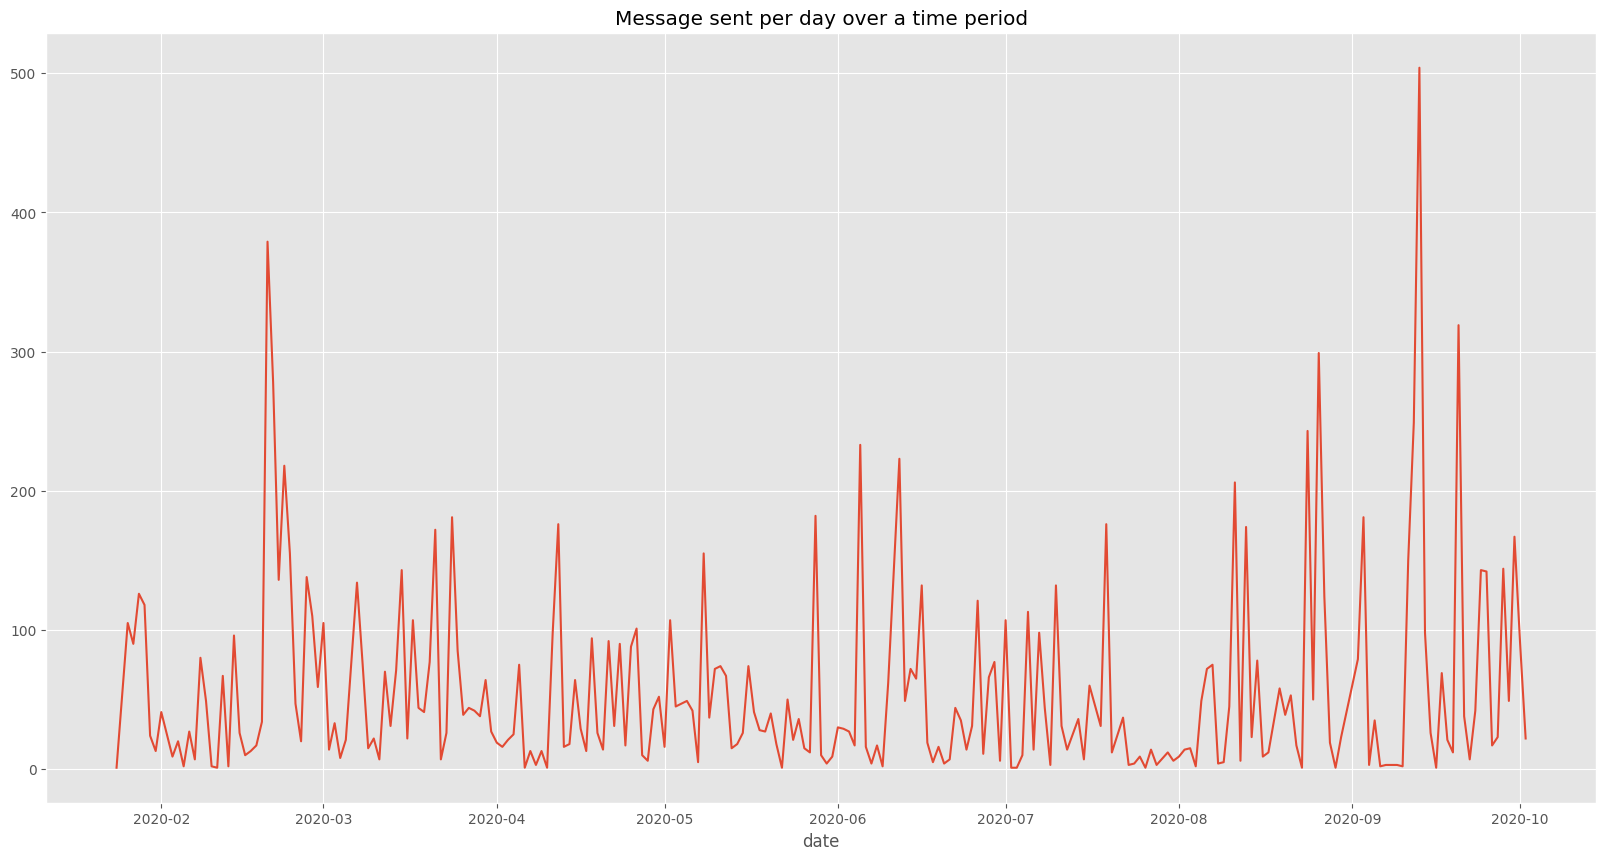

<Axes: title={'center': 'Message sent per day over a time period'}, xlabel='date'>

In [9]:
nb_message(chat_df)

## Top 10 most active days during the period

In [10]:
def top10days(df):
    top10days = (df.groupby('date')['text'].count()).sort_values(ascending = False).head(10)
    top10days.plot(kind = 'bar', color = plt.cm.rainbow(np.linspace(0, 1, 10)))
    plt.ylabel('Messages count')
    plt.xlabel('Date')
    plt.xticks(rotation=45, ha = 'right')
    plt.title('Top 10 most active days')
    plt.show()
    return top10days

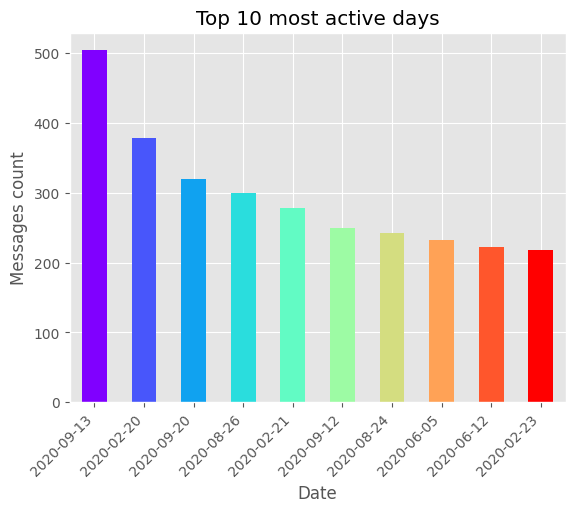

date
2020-09-13    504
2020-02-20    379
2020-09-20    319
2020-08-26    299
2020-02-21    278
2020-09-12    249
2020-08-24    243
2020-06-05    233
2020-06-12    223
2020-02-23    218
Name: text, dtype: int64

In [11]:
top10days(chat_df)

## Monthly activity

In [12]:
def topmonths (df):
    topmonths = df['month'].value_counts().reset_index()
    topmonths.columns = ['month','count']
    topmonths = topmonths.sort_values('month', ascending = False)
    plt.figure(figsize=(10,6))
    plt.barh(topmonths['month'], topmonths['count'])
    plt.xlabel('Count')
    plt.ylabel('Month')
    plt.title('Chat per month')
    plt.tight_layout()
    plt.show()
    return topmonths.sort_values('count',ascending = False)

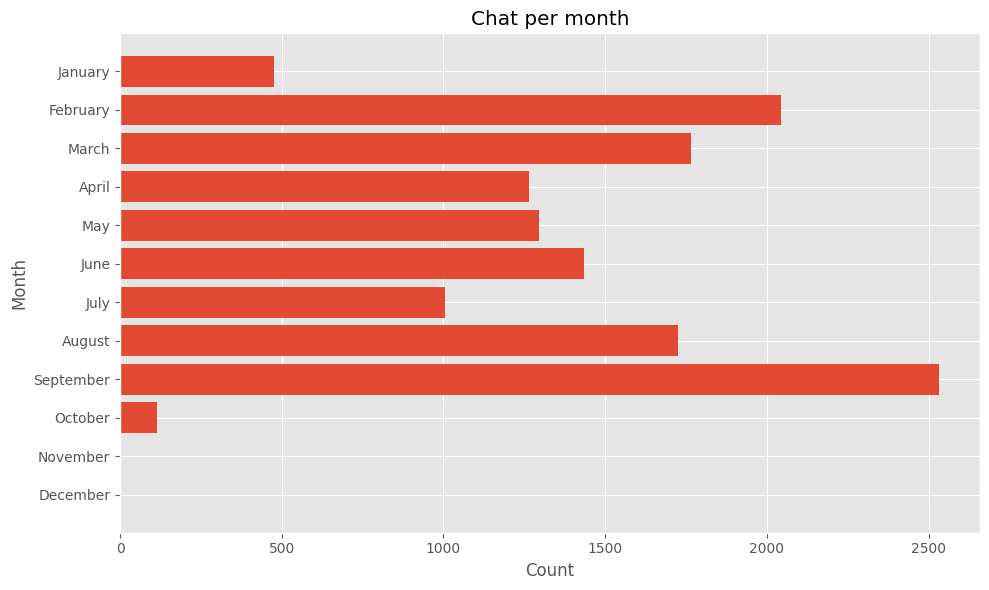

,month,count
0,September,2532
1,February,2043
2,March,1766
3,August,1725
4,June,1434
5,May,1296
6,April,1265
7,July,1004
8,January,477
9,October,113


In [13]:
topmonths(chat_df)

## Daily activity

In [14]:
def topdays(df):
    topdays = df['day'].value_counts().reset_index()
    topdays.columns = ['day','count']
    topdays = topdays.sort_values('day')

    fig = px.line_polar(topdays, r='count', theta = 'day', line_close = True)
    fig.update_traces(fill = 'toself')
    fig.update_layout(polar = dict(radialaxis = dict(visible = True)),
                      showlegend = True, title = {'text' : 'Chat per day of week'})
    fig.show()
    return topdays.sort_values('count', ascending = False)

In [15]:
topdays(chat_df)

,day,count
0,Sunday,2670
1,Thursday,2191
2,Friday,2161
3,Saturday,1921
4,Wednesday,1675
5,Tuesday,1552
6,Monday,1485


## Daily active time

In [16]:
def tophours(df):
    tophours = df.groupby('hour_int').size()
    plt.figure(figsize =(10,6))
    plt.plot(tophours.index,
             tophours.values,
             marker = 'o')
    plt.title('Daily active time')
    plt.xlabel('Hour of the day')
    plt.ylabel('Amount of chats')
    plt.grid(True)
    plt.xticks(range(0,24))
    plt.show()


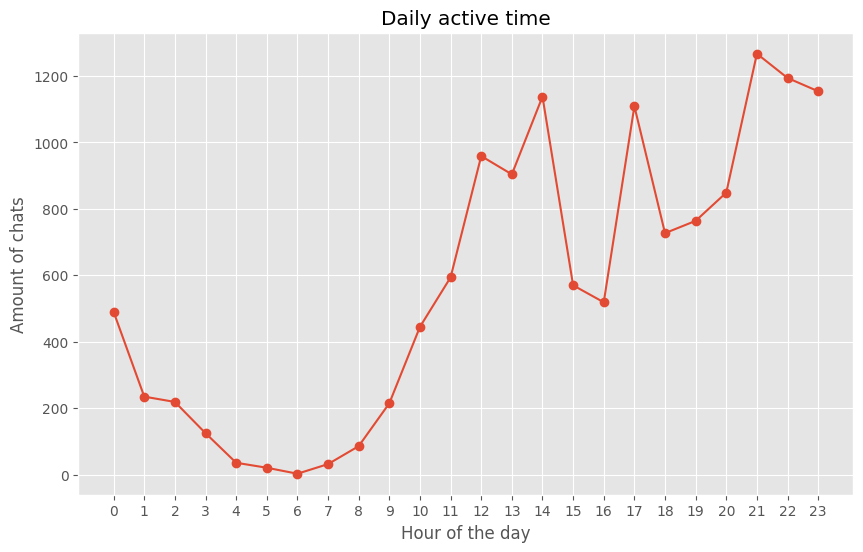

In [17]:
tophours(chat_df)

## Heat map of month activity and day activity



In [18]:
def group_month_day(df):
        grouped_by_month_day = df.groupby(['month', 'day'])['text'].value_counts().reset_index(name = 'count')
        pivot = grouped_by_month_day.pivot_table(index = 'month', columns = 'day',
                                         values = 'count')
        sns.heatmap(pivot, cmap = 'cividis')
        plt.xticks(rotation=45, ha = 'right')
        plt.title('Heat map of monthly activity and daily activity')
        plt.show()


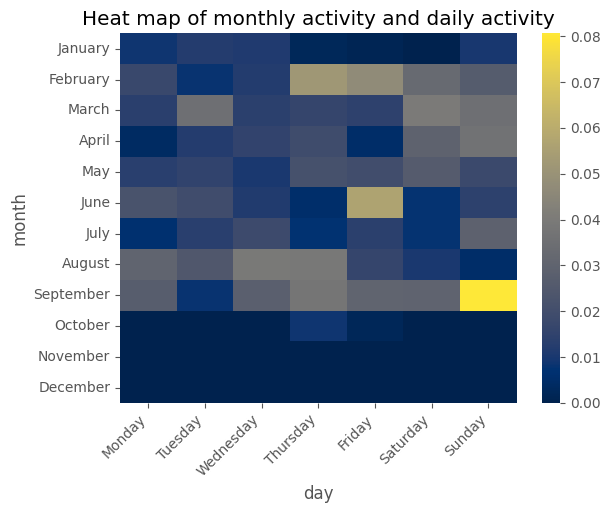

In [19]:
group_month_day(chat_df)

###**Inference**

The intensity of group chat activity is represented by color : the lighter shades indicating higher levels of engageent.

A consistent pattern shows the group is more active on weekends throughout all months.

September stands out as the most active month in the chat: this month has the most ligher blue shaed and more yellow gradients.

## Most used words


In [20]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
  #Stopwords
  #Use set to avoid repeatd words
custom_stopwords = {'group', 'link', 'invite', 'joined',
                    'message', 'deleted', 'yeah', 'hai',
                    'yes', 'okay', 'ok', 'will', 'use',
                    'using', 'one', 'know', 'guy', 'group',
                    'media', 'omitted'}
stopwords = custom_stopwords.union(set(STOPWORDS)).union(set(nltk.corpus.stopwords.words('english')))

In [22]:
def wordcloud(row):
        text = row.str.lower()
        text_str = ' '.join(text.tolist())
        wordcloud = WordCloud(width = 800, height = 400,
                             random_state = 42, stopwords = stopwords,
                             background_color = 'white').generate(text_str)
        plt.figure(figsize=(10,5))
        plt.imshow(wordcloud, interpolation ='bilinear')
        plt.axis('off')
        plt.title('Most common words in the chat')
        plt.show()


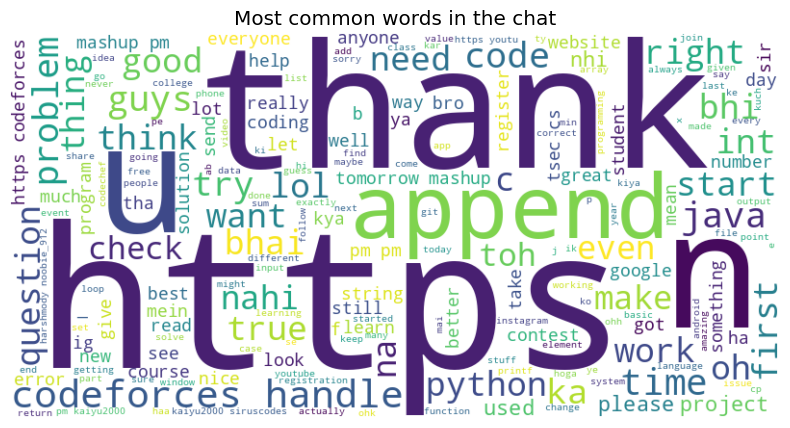

In [23]:
wordcloud(chat_df['text'])

## Most active users

In [24]:
def top10users(df):
      #Ignore notifications
    df = df[df.user!= 'notification']
      #Ignore phone numbers
    def is_phone_number(s):
            pattern = r'^\+?[\d\s()-]{10,}$'
            return bool(re.match(pattern, s))
    df = df[~df['user'].apply(is_phone_number)]

    top10users = df['user'].value_counts().sort_values(ascending = False).head(10).reset_index()
    top10users.columns = ['user', 'msg_sent']
      #Hide names and get the initials
    def get_initials(name):
        name = re.sub(r'\([^)]*\)', '', name)
        words = name.split()
        initials = ' '.join(word[0].upper() for word in words if word)
        return initials[:3]

    top10users['initials'] = top10users['user'].apply(get_initials)
    top10users.drop('user', axis = 1, inplace =True)

    plt.figure(figsize=(12, 6))
    sns.barplot(x='initials', y='msg_sent', data=top10users)
    plt.xlabel('Users initial')
    plt.ylabel('Message sent')
    plt.title('10 most active users')
    plt.show()

    return top10users

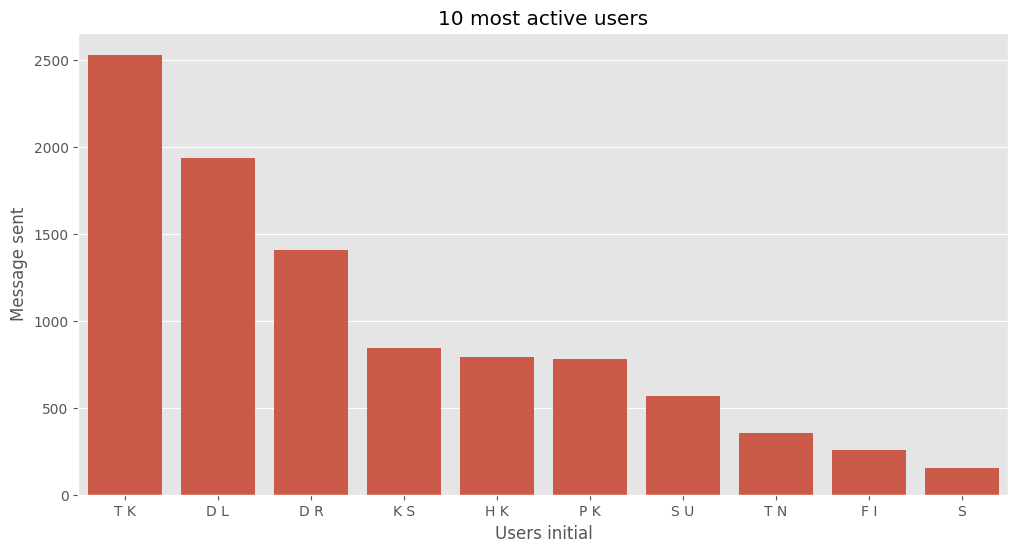

,msg_sent,initials
0,2528,T K
1,1937,D L
2,1404,D R
3,841,K S
4,790,H K
5,781,P K
6,569,S U
7,354,T N
8,255,F I
9,153,S


In [25]:
top10users(chat_df)

## Sentiment Analysis  

In [26]:
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [27]:
sentiments = SentimentIntensityAnalyzer()
def get_sentiment(text):
    scores = sentiments.polarity_scores(text)
    if scores['pos'] > scores['neg'] and scores['pos'] > scores['neu']:
        return 'Positive'
    elif scores['neg'] > scores['pos'] and scores['neg'] > scores['neu']:
        return 'Negative'
    else :
        return 'Neutral'

def sentiment_score(df):
    df['Positive'] = [sentiments.polarity_scores(i)['pos']
                      for i in df['text']]
    df['Negative'] = [sentiments.polarity_scores(i)['neg']
                     for i in df['text']]
    df['Neutral'] = [sentiments.polarity_scores(i)['neu']
                    for i in df['text']]
    df['Sentiment'] = df['text'].apply(get_sentiment)

    mask = df['user'] =='notification'
    df.loc[mask, ['Positive', 'Negative', 'Neutral', 'Sentiment']] = 'NA'

    return df.sample(10)

In [28]:
sentiment_score(chat_df)

,user,text,date,hour,hour_int,day,month,Positive,Negative,Neutral,Sentiment
533,+91 89764 07509,just check please,2020-02-04,20:03:00,20,Tuesday,February,0.535,0.0,0.465,Positive
6701,"Harsh Kapadia (TSEC IT, SE)",True true,2020-05-28,02:40:00,2,Thursday,May,1.0,0.0,0.0,Positive
10893,"Kartik Soneji (TSEC, CS)",I am not convinced.,2020-08-27,21:48:00,21,Thursday,August,0.0,0.53,0.47,Negative
1865,+91 93243 92133,Can't compile file: program.c: In function 'ma...,2020-02-23,12:18:00,12,Sunday,February,0.0,0.164,0.836,Neutral
4677,"Saurav Upoor (TSEC CS, SE)",Private testcases and others submissions now v...,2020-04-12,16:53:00,16,Sunday,April,0.0,0.0,1.0,Neutral
8771,"Pratik K (TSEC CS, SE)",It just shows Your mac is up to date,2020-07-10,19:34:00,19,Friday,July,0.0,0.0,1.0,Neutral
10686,+91 97681 67131,Ya Agreed,2020-08-26,12:23:00,12,Wednesday,August,0.677,0.0,0.323,Positive
11407,"Dheeraj Lalwani (TSEC, CS)",And the rest is history,2020-09-11,11:27:00,11,Friday,September,0.0,0.0,1.0,Neutral
5591,"Tanay Kamath (TSEC, CS)",yes bim using,2020-05-02,16:57:00,16,Saturday,May,0.574,0.0,0.426,Positive
844,"Dheeraj Lalwani (TSEC, CS)",We want linear complexity,2020-02-14,19:53:00,19,Friday,February,0.302,0.0,0.698,Neutral


In [29]:
def chat_sentiment(df):
    chat_filtered = df[df['Sentiment']!='NA']
    chat_sentiment = chat_filtered['Sentiment'].value_counts().sort_values().reset_index()
    chat_sentiment.columns = ['sentiment', 'count']
    plt.figure(figsize = (7,7))
    plt.pie(chat_sentiment['count'], labels = chat_sentiment['sentiment'],
            autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title('Chat Sentiment Distribution')
    plt.show()


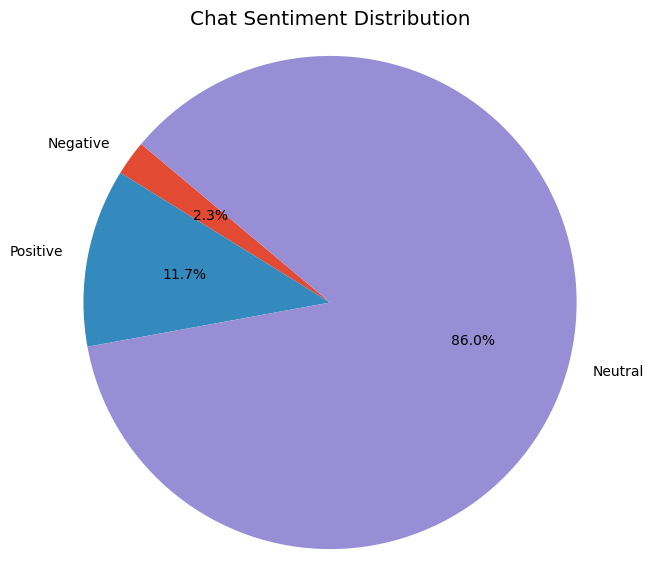

In [30]:
chat_sentiment(chat_df)

## Most used emojis

In [31]:
  #Extract emojis from text
def extract_emojis(text):
    emoji_list = [char for char in text if char in emoji.EMOJI_DATA]
    return emoji_list

  #Count the extracted emojis
def top_emojis(df):
    def count(df):
        all_emojis = []
        for text in df['text']:
            all_emojis.extend(extract_emojis(text))
        emoji_counts = Counter(all_emojis)
        return emoji_counts
    emoji_counts = count(df)

    #Convert to dataframe
    emoji_df = pd.DataFrame.from_dict(emoji_counts, orient = 'index',
                                          columns = ['count'])
    emoji_df = emoji_df.reset_index()
    emoji_df = emoji_df.rename(columns = {'index' : 'emoji'})
    top10emojis = emoji_df.sort_values('count', ascending = False).head(10)
    fig = px.treemap(top10emojis, path= ['emoji'],
                 values = top10emojis['count'].tolist())
    fig.update_layout(title = {'text' : 'Tree map of the top 10 emojis'})

    fig.show()

    return top10emojis


In [32]:
top_emojis(chat_df)



,emoji,count
5,😂,1896
7,👍,365
12,🏻,336
20,🔥,254
9,😅,224
26,💯,185
23,♂,169
22,🤦,136
32,🤣,132
103,👏,103
